# testing WDM on zf

## imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scanpy -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sys
import importlib

In [4]:
filehandle_wdm = 'drive/Othercomputers/numac/GitHub/WDM/'
filehandle_save = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save/'
filehandle_zf = 'drive/MyDrive/DX/_data/zebrafish/cleaned_common_pca/'

sys.path.insert(0, filehandle_wdm)
sys.path.insert(0, filehandle_save)
sys.path.insert(0, filehandle_zf)

import clustering
import util_LR
import util_zf
import FRLC_LRDist

## reload

In [5]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(FRLC_LRDist)

<module 'FRLC_LRDist' from '/content/drive/Othercomputers/numac/GitHub/WDM/FRLC_LRDist.py'>

## device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

On device: cuda


## load zf: spatial, annotation hard clusterings as $Q$'s

In [7]:
# daniocell_dir = '/scratch/gpfs/ph3641/zebrafish/daniocell.h5ad'
# adata_daniocell = sc.read_h5ad(daniocell_dir)
# stages = np.unique(adata_daniocell.obs['hpf'].values)

zf_list = ['zf3', 'zf5', 'zf10', 'zf12', 'zf18', 'zf24']
zf_names = zf_list
filehandles_zf = [filehandle_zf + 'pair' + str(k) + '/' for k in range(len(zf_list))]
N = len(filehandles_zf)

spatial_list = []
exclude_rows = [None, None, None, None, None, None] # [1099, None, None, 325, None, None]

for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    nidx = exclude_rows[i]
    if nidx is not None:
        spatial = np.concatenate((spatial[:nidx,:], spatial[nidx+1:,:]))
    spatial_list.append(spatial)

In [8]:
N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)

key = 'bin_annotation'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')

    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')

    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    # sc.pp.normalize_total(adata1)
    # sc.pp.log1p(adata1)

    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    # sc.pp.normalize_total(adata2)
    # sc.pp.log1p(adata2)

    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)

    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))

    if i == 0:
        labels.append(list(encoder1.categories_[0]))

    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))

    Qs[i], Rs[i] = _Q, _R

Slice pair 4, aligning zf18 to zf24
Slice pair 3, aligning zf12 to zf18
Slice pair 2, aligning zf10 to zf12
Slice pair 1, aligning zf5 to zf10
Slice pair 0, aligning zf3 to zf5


## set ranks, set `i` = first timepoint of three: `i`, `i+1`, `i+2`

In [9]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]
# exclude_rows = [1099, None, None, 325, None, None]

i=2

## load features and spatial coords specific to the triple

In [10]:
s1_name = zf_names[i]
s2_name = zf_names[i+1]
s3_name = zf_names[i+2]

filehandle_pair1 = filehandle_zf + 'pair' + str(i) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(i+1) + '/'

X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair1 + s2_name + '_feature.npy')
X3 = np.load(filehandle_pair2 + s3_name + '_feature.npy')

S1 = spatial_list[i]
S2 = spatial_list[i+1]
S3 = spatial_list[i+2]

## form cost matrices

In [11]:
C12_np = cdist(X1, X2)
C23_np = cdist(X2, X3)

A11_np = cdist(S1, S1)
A22_np = cdist(S2, S2)
A33_np = cdist(S3, S3)

In [12]:
C12 = torch.from_numpy(C12_np).to(device)
C23 = torch.from_numpy(C23_np).to(device)

A11 = torch.from_numpy(A11_np).to(device)
A22 = torch.from_numpy(A22_np).to(device)
A33 = torch.from_numpy(A33_np).to(device)

## set ranks, excluded rows for triple

In [14]:
r1, r2 = ranks[i]
r2, r3 = ranks[i+1]
nidx_1, nidx_2, nidx_3 = exclude_rows[i], exclude_rows[i+1], exclude_rows[i+2]

## factor cost matrices

In [15]:
C_factors12, A_factors11, A_factors22 = util_zf.factor_mats(C12, A11_np, A22_np, \
                                                device, z=400, c=100, nidx_1=nidx_1, nidx_2=nidx_2)

C_factors23, A_factors22, A_factors33 = util_zf.factor_mats(C23, A22_np, A33_np, \
                                                device, z=400, c=100, nidx_1=nidx_2, nidx_2=nidx_3)

c = max(torch.max(C_factors12[0] @ C_factors12[1]), torch.max( C_factors23[0] @ C_factors23[1]))
c = max(c, 1/c)

C_factors12 = (C_factors12[0]/c, C_factors12[1]/c)
C_factors23 = (C_factors23[0]/c, C_factors23[1]/c)

C done
A done
B done
C done
A done
B done


## run `WDM`

Aligning slices zf10 to zf12 to zf18
Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Iteration: 150
Iteration: 175
Initial Wasserstein cost: 2.641129650376617e-09, Triplet cost: 6.920496588691455e-11, (partial) GW-cost: -1.4435760949713553e-15, Total cost: 2.3770165409813456e-09
Final Wasserstein cost: 2.3291930370546987e-09, Triplet cost: 5.527622708186895e-11, (partial) GW-cost: -1.5636048293367071e-15, Total cost: 2.096273576988746e-09


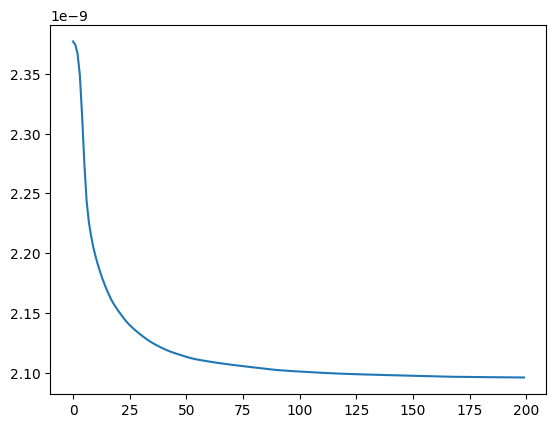

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Iteration: 150
Iteration: 175
Initial Wasserstein cost: 2.950484520182683e-09, Triplet cost: 3.305666296975174e-11, (partial) GW-cost: -7.745962887003681e-16, Total cost: 2.655435990704786e-09
Final Wasserstein cost: 2.652113594615944e-09, Triplet cost: 2.5411356422170195e-11, (partial) GW-cost: -8.544345844231237e-16, Total cost: 2.3869021497108912e-09


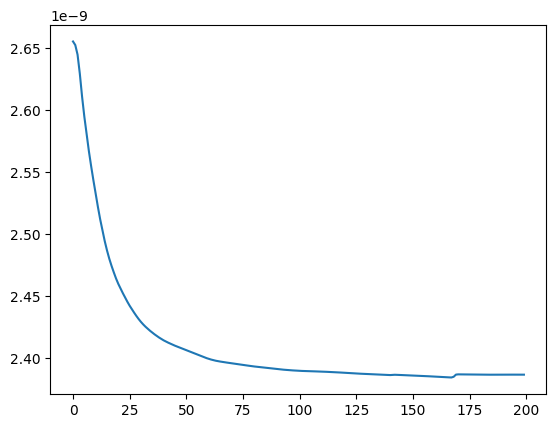

Ranks: r1 7, r2 11, r3 14
Iteration: 0
tensor(-3.9101e-08, device='cuda:0', dtype=torch.float64)
tensor(2.3164e-08, device='cuda:0', dtype=torch.float64)
tensor(1.0427e-06, device='cuda:0', dtype=torch.float64)
tensor(2.1797e-06, device='cuda:0', dtype=torch.float64)
tensor(1.8910e-06, device='cuda:0', dtype=torch.float64)
tensor(3.3268e-06, device='cuda:0', dtype=torch.float64)
tensor(2.4491e-06, device='cuda:0', dtype=torch.float64)
tensor(3.8113e-06, device='cuda:0', dtype=torch.float64)
tensor(2.8406e-06, device='cuda:0', dtype=torch.float64)
tensor(4.0884e-06, device='cuda:0', dtype=torch.float64)
tensor(3.1425e-06, device='cuda:0', dtype=torch.float64)
tensor(4.2927e-06, device='cuda:0', dtype=torch.float64)
tensor(3.4281e-06, device='cuda:0', dtype=torch.float64)
tensor(4.4457e-06, device='cuda:0', dtype=torch.float64)
tensor(3.6409e-06, device='cuda:0', dtype=torch.float64)
tensor(4.5655e-06, device='cuda:0', dtype=torch.float64)
tensor(3.7966e-06, device='cuda:0', dtype=torch.

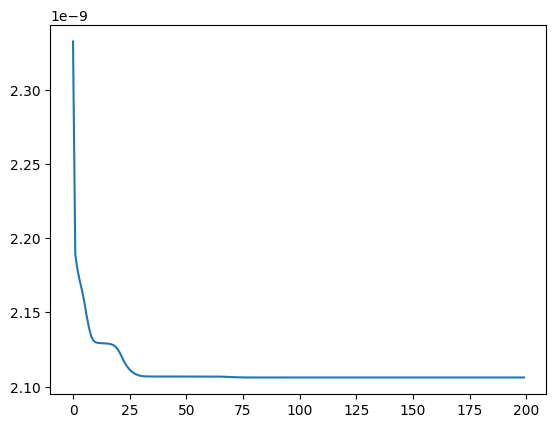

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Iteration: 150
Iteration: 175
Initial Wasserstein cost: 2.9388366967587825e-09, Triplet cost: 2.9399184230633585e-11, (partial) GW-cost: -7.702466595262907e-16, Total cost: 2.6449529500582382e-09
Final Wasserstein cost: 2.6893307495459553e-09, Triplet cost: 2.6421318612150546e-11, (partial) GW-cost: -8.211002308181519e-16, Total cost: 2.4203975924813365e-09


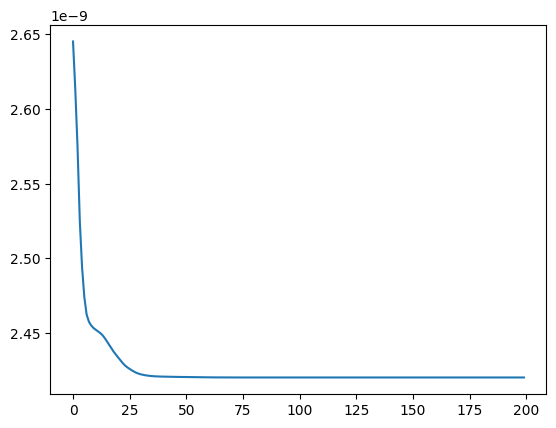

In [16]:
import importlib
import WassersteinDiffMap
importlib.reload(WassersteinDiffMap)

gamma=30
tau_out=1
tau_in=1e-6 #5
alpha = 0.1 #0.8 #0.98
beta = 0.0

ranks = [(7,11),(11,14)]
C_factors_sequence, A_factors_sequence = (C_factors12, C_factors23), (A_factors11, A_factors22, A_factors33)

print(f'Aligning slices {s1_name} to {s2_name} to {s3_name}')

WDM = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                  gamma=gamma, max_iter=200, min_iter=200, device=device, dtype=torch.float64, \
                 printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                  initialization='Full', init_args = None)

WDM.gamma_smoothing(C_factors_sequence, A_factors_sequence)

## save

In [17]:
Q0, Q1, Q2 = WDM.Q_gammas[0], WDM.Q_gammas[1], WDM.Q_gammas[2]
T0, T1 = WDM.T_gammas[0], WDM.T_gammas[1]

Q0_np = Q0.cpu().numpy()
Q1_np = Q1.cpu().numpy()
Q2_np = Q2.cpu().numpy()

T0_np = T0.cpu().numpy()
T1_np = T1.cpu().numpy()

np.save(filehandle_save + 'wdm_Q0.npy', Q0_np)
np.save(filehandle_save + 'wdm_Q1.npy', Q1_np)
np.save(filehandle_save + 'wdm_Q2.npy', Q2_np)

np.save(filehandle_save + 'wdm_T0.npy', T0_np)
np.save(filehandle_save + 'wdm_T1.npy', T1_np)

## compare to case where clusters at $t_{1}, t_{3}$ fixed from annotations

In [19]:
# Initialize as arguments
init_args = (Qs[i].type(torch.DoubleTensor).to(device), Rs[i+1].type(torch.DoubleTensor).to(device))
Q0_ann, Q2_ann = init_args

# Learn smoothed co-clustering Q_t
Q1_imp, T0_ann_imp, T1_ann_imp = FRLC_LRDist.FRLC_LR_opt_multimarginal(C_factors12, \
                                              A_factors11, \
                                             A_factors22, \
                                                C_factors23, \
                                              A_factors22, \
                                             A_factors33,  \
                                            r=r2, max_iter=120, device=device, \
                                             returnFull=False, alpha=alpha, beta=beta, \
                                            min_iter = 100, initialization='Full', tau_out=tau_out, tau_in=tau_in, gamma=gamma, \
                                            dtype=torch.float64, init_args=init_args)
gQ = Q1_imp.T @ torch.ones(Q1_imp.shape[0]).type(torch.DoubleTensor).to(device)
print(gQ)

Ranks: r1 7, r2 11, r3 14
Iteration: 0
tensor(-4.0284e-08, device='cuda:0', dtype=torch.float64)
tensor(8.3449e-08, device='cuda:0', dtype=torch.float64)
tensor(5.0890e-07, device='cuda:0', dtype=torch.float64)
tensor(1.8009e-06, device='cuda:0', dtype=torch.float64)
tensor(8.4271e-07, device='cuda:0', dtype=torch.float64)
tensor(2.6299e-06, device='cuda:0', dtype=torch.float64)
tensor(1.1029e-06, device='cuda:0', dtype=torch.float64)
tensor(2.9937e-06, device='cuda:0', dtype=torch.float64)
tensor(1.4070e-06, device='cuda:0', dtype=torch.float64)
tensor(3.2019e-06, device='cuda:0', dtype=torch.float64)
tensor(1.5616e-06, device='cuda:0', dtype=torch.float64)
tensor(3.3393e-06, device='cuda:0', dtype=torch.float64)
tensor(1.6837e-06, device='cuda:0', dtype=torch.float64)
tensor(3.4412e-06, device='cuda:0', dtype=torch.float64)
tensor(1.7864e-06, device='cuda:0', dtype=torch.float64)
tensor(3.5162e-06, device='cuda:0', dtype=torch.float64)
tensor(1.8729e-06, device='cuda:0', dtype=torch.

## save these as well

In [20]:
Q0, Q1, Q2 = Q0_ann, Q1_imp, Q2_ann
T0, T1 = T0_ann_imp, T1_ann_imp

Q0_np = Q0.cpu().numpy()
Q1_np = Q1.cpu().numpy()
Q2_np = Q2.cpu().numpy()

T0_np = T0.cpu().numpy()
T1_np = T1.cpu().numpy()

np.save(filehandle_save + 'ann_Q0.npy', Q0_np)
np.save(filehandle_save + 'ann_Q1_imp.npy', Q1_np)
np.save(filehandle_save + 'ann_Q2.npy', Q2_np)

np.save(filehandle_save + 'ann_T0_imp.npy', T0_np)
np.save(filehandle_save + 'ann_T1_imp.npy', T1_np)

## finally, find diffmaps when all three slices have fixed annotations

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Iteration: 150
Iteration: 175
Initial Wasserstein cost: 2.5714494375461255e-09, Triplet cost: 5.2146343056215276e-11, (partial) GW-cost: -1.5590760316981679e-15, Total cost: 2.31430433788391e-09
Final Wasserstein cost: 2.4735131156917922e-09, Triplet cost: 4.628288179761567e-11, (partial) GW-cost: -1.7229618955155324e-15, Total cost: 2.2261616318264236e-09


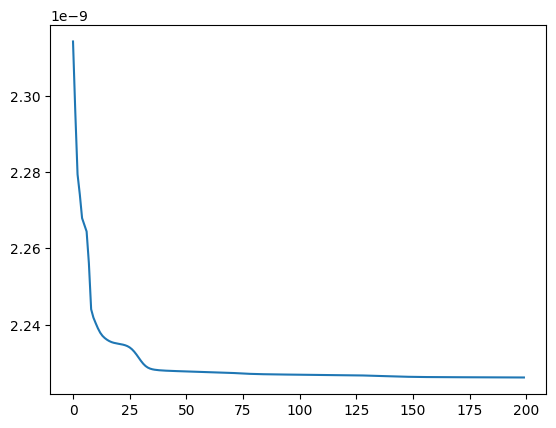

Iteration: 0
Iteration: 25
Iteration: 50
Iteration: 75
Iteration: 100
Iteration: 125
Iteration: 150
Iteration: 175
Initial Wasserstein cost: 2.953430131039743e-09, Triplet cost: 2.6831036867667332e-11, (partial) GW-cost: -7.940305377146833e-16, Total cost: 2.658087038532715e-09
Final Wasserstein cost: 2.821389971010762e-09, Triplet cost: 2.1413875320730175e-11, (partial) GW-cost: -9.907642305630025e-16, Total cost: 2.539250874833263e-09


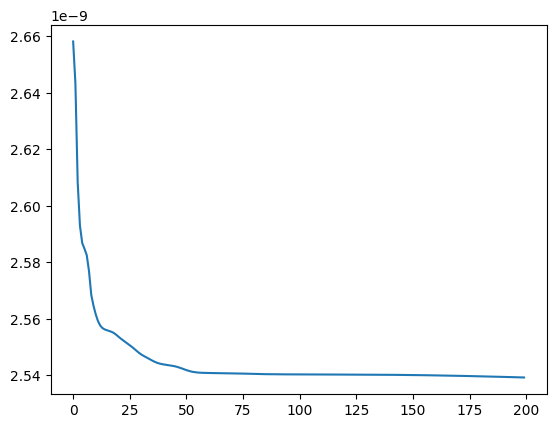

In [22]:
importlib.reload(WassersteinDiffMap)

WDM2 = WassersteinDiffMap.WassersteinDifferentiationMapping(ranks, tau_in = tau_in, tau_out=tau_out, \
                  gamma=gamma, max_iter=200, min_iter=200, device=device, dtype=torch.float64, \
                 printCost=True, returnFull=False, alpha=alpha, beta=beta, \
                  initialization='Full', init_args = None)
Q_annot = [Qs[i].type(torch.DoubleTensor).to(device), Qs[i+1].type(torch.DoubleTensor).to(device), Qs[i+2].type(torch.DoubleTensor).to(device)]
WDM2.impute_annotated_transitions(C_factors_sequence, A_factors_sequence, Q_annot)


## save these

In [23]:
Q0, Q1, Q2 = WDM2.Q_gammas[0], WDM2.Q_gammas[1], WDM2.Q_gammas[2]
T0, T1 = WDM2.T_gammas[0], WDM2.T_gammas[1]

Q0_np = Q0.cpu().numpy()
Q1_np = Q1.cpu().numpy()
Q2_np = Q2.cpu().numpy()

T0_np = T0.cpu().numpy()
T1_np = T1.cpu().numpy()

np.save(filehandle_save + 'ann_Q0.npy', Q0_np)
np.save(filehandle_save + 'ann_Q1.npy', Q1_np)
np.save(filehandle_save + 'ann_Q2.npy', Q2_np)

np.save(filehandle_save + 'ann_T0.npy', T0_np)
np.save(filehandle_save + 'ann_T1.npy', T1_np)